In [ ]:
from __future__ import division, print_function  # Совместимость с Python 2 (если требуется)
# Отображение графиков внутри ноутбука
%matplotlib inline
from matplotlib import pyplot as plt  # Для визуализации
import seaborn as sns  # Для более красивых графиков
from google.colab import files  # Для загрузки/выгрузки файлов в Google Colab
import pickle  # Для сохранения и загрузки объектов (например, моделей)
import numpy as np  # Работа с массивами
import pandas as pd  # Работа с таблицами данных
from scipy.sparse import csr_matrix, hstack  # Разреженные матрицы
from sklearn.preprocessing import StandardScaler  # Масштабирование данных
from sklearn.metrics import roc_auc_score, roc_curve, auc  # Метрики для оценки качества
from sklearn.linear_model import LogisticRegression  # Логистическая регрессия
from sklearn.model_selection import train_test_split, GridSearchCV  # Разделение данных и поиск параметров


## Лабораторная работа 5: Логистическая регрессия
Суть: Применение логистической регрессии для решения задач классификации. Построение вероятностных моделей.

Сигмоидная функция: Математическая функция, преобразующая значения в диапазон от 0 до 1, интерпретируемые как вероятность.

Градиентный спуск: Метод оптимизации, использующий итеративное улучшение параметров модели для минимизации ошибки.

Перекрестная энтропия: Функция потерь для задач классификации, оценивающая разницу между истинным и предсказанным распределением вероятностей.

Граница классификации: Значение (например, 0.5), по которому определяется, к какому классу относится объект.


In [ ]:
uploaded = files.upload()

Saving WineQT.csv to WineQT.csv


In [ ]:
# 1. Загрузка данных
data_path = 'WineQT.csv'
df = pd.read_csv(data_path)

# Анализ структуры данных
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB
None
       fixed acidity  volatile acidity  citric acid  residual sugar  \

2.1 В рамках выполнения задания необходимо ввести 2 новых
синтезированных признака, оценить изменение точности модели после
добавления признаков (с применением масштабирования признаков и без).

In [ ]:
# Создание целевой переменной `target`: качество выше медианного значения — класс 1, иначе — класс 0
df['target'] = (df['quality'] > df['quality'].median()).astype(int)

# 2.1 Создание синтезированных признаков
df['acidity_ratio'] = df['fixed acidity'] / df['volatile acidity']
df['sugar_density_ratio'] = df['residual sugar'] / df['density']

# Выбор признаков
X = df[['acidity_ratio', 'sugar_density_ratio', 'alcohol', 'sulphates']]
y = df['target']  # Целевая переменная

# Вывод выбранных признаков
print("\nПризнаки для обучения:")
print(X.head())

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Замена NaN значений на медиану
X_train = X_train.apply(lambda x: x.fillna(x.median()), axis=0)
X_test = X_test.apply(lambda x: x.fillna(x.median()), axis=0)
y_train = y_train.fillna(y_train.median())
y_test = y_test.fillna(y_test.median())

# Просмотр размеров тренировочного и тестового наборов
print("\nРазмеры наборов данных:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Вывод первых 5 строк после масштабирования
print("\nПервые 5 строк после масштабирования:")
print(X_train_scaled[:5])



Признаки для обучения:
   acidity_ratio  sugar_density_ratio  alcohol  sulphates
0      10.571429             1.904189      9.4       0.56
1       8.863636             2.608347      9.8       0.68
2      10.263158             2.306921      9.8       0.65
3      40.000000             1.903808      9.8       0.58
4      10.571429             1.904189      9.4       0.56

Размеры наборов данных:
X_train: (914, 4), X_test: (229, 4)
y_train: (914,), y_test: (229,)

Первые 5 строк после масштабирования:
[[ 1.34936635 -0.55262868  0.05661327  0.56821234]
 [ 1.41260566 -0.39644188  0.89445566  0.4477703 ]
 [ 1.16984828  0.06504803  1.26683005  0.20688622]
 [-1.14128986 -0.2441586  -0.50194833 -0.57598704]
 [ 0.01323307  1.05920135 -1.24669712 -0.51576602]]


2.2 После определения необходимого набора признаков необходимо
сформировать
набор
значений
гипперпараметра
модели
и
выбрать
оптимальное значение. Постройте график (AUC-ROC, гипперпараметр C).

In [ ]:
# 2.2 Обучение логистической регрессии с различными гиперпараметрами
params = {'C': np.logspace(-3, 3, 10)}  # Сетка значений гиперпараметра

# Создание объекта логистической регрессии
lr = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')  # Используем 'liblinear' для стабильности

# Настройка GridSearchCV для подбора гиперпараметров
grid = GridSearchCV(lr, params, scoring='roc_auc', cv=5)  # Оценка по AUC-ROC, 5-фолдовая кросс-валидация
grid.fit(X_train_scaled, y_train)  # Обучение модели с подбором гиперпараметров

# Извлечение оптимального гиперпараметра
best_model = grid.best_estimator_  # Модель с наилучшей производительностью
best_C = grid.best_params_['C']  # Извлечение оптимального значения C
print(f"Лучшее значение C: {best_C}")


Лучшее значение C: 0.021544346900318832


In [ ]:
# 2.3 Оценка модели

# Предсказание вероятностей для тестового набора
y_pred_prob = best_model.predict_proba(X_test_scaled)[:, 1]  # Вероятности принадлежности к классу 1

# Вычисление AUC-ROC
auc_score = roc_auc_score(y_test, y_pred_prob)  # AUC-ROC для проверки качества классификации
print(f"AUC-ROC: {auc_score}")


AUC-ROC: 0.902096659559346


**Подготовка значений гиперпараметра C и обучение модели для каждого значения C и расчёт AUC-ROC**

Этот фрагмент создаёт список значений для гиперпараметра C, который будет варьироваться от 10^-3 до 10^3 (с шагом в логарифмическом масштабе). А также здесь для каждого значения C модель обучается и рассчитывается AUC-ROC. Мы сохраняем AUC-ROC в список scores для дальнейшего построения графика.

In [ ]:
# Список значений гиперпараметра C
Cs = np.logspace(-5, 5, 10)
# Список для хранения значений AUC-ROC для каждого C
scores = []

# Обучение модели и расчет AUC-ROC для каждого значения C
for C_val in Cs:
    # Создаем модель логистической регрессии с текущим значением C
    lr = LogisticRegression(C=C_val, max_iter=1000, random_state=42)
    # Обучение модели на тренировочных данных
    lr.fit(X_train_scaled, y_train)

    # Получение вероятностей для расчета AUC-ROC
    y_pred_prob = lr.predict_proba(X_test_scaled)[:, 1]

    # Расчет AUC-ROC на основе тестовых данных
    auc_score = roc_auc_score(y_test, y_pred_prob)
    scores.append(auc_score)

# Результат: список AUC-ROC значений для всех C
print("Значения AUC-ROC для разных C:", scores)


Значения AUC-ROC для разных C: [0.8978322672352523, 0.8976545842217484, 0.898365316275764, 0.9017412935323382, 0.9010305614783227, 0.9010305614783226, 0.9010305614783226, 0.9010305614783226, 0.9010305614783226, 0.9010305614783226]


**Получение AUC-ROC для дефолтного значения C=1**

Здесь мы обучаем модель с дефолтным значением C=1, рассчитываем AUC-ROC и сохраняем это значение в score_C_1.

In [ ]:
# Обучение модели логистической регрессии с дефолтным значением C (C=1)
lr_default = LogisticRegression(C=1, max_iter=1000, random_state=42)
# Обучение модели на тренировочных данных
lr_default.fit(X_train_scaled, y_train)

# Получение вероятностей для класса 1
y_pred_prob_default = lr_default.predict_proba(X_test_scaled)[:, 1]

# Вычисление AUC-ROC на тестовой выборке
score_C_1 = roc_auc_score(y_test, y_pred_prob_default)

# Вывод результата
print(f"AUC-ROC для C=1: {score_C_1}")


AUC-ROC для C=1: 0.9010305614783226


**Построение графика AUC-ROC от значения C**

Этот фрагмент строит график зависимости AUC-ROC от значения гиперпараметра C. Мы также добавляем горизонтальную линию для дефолтного значения C=1.

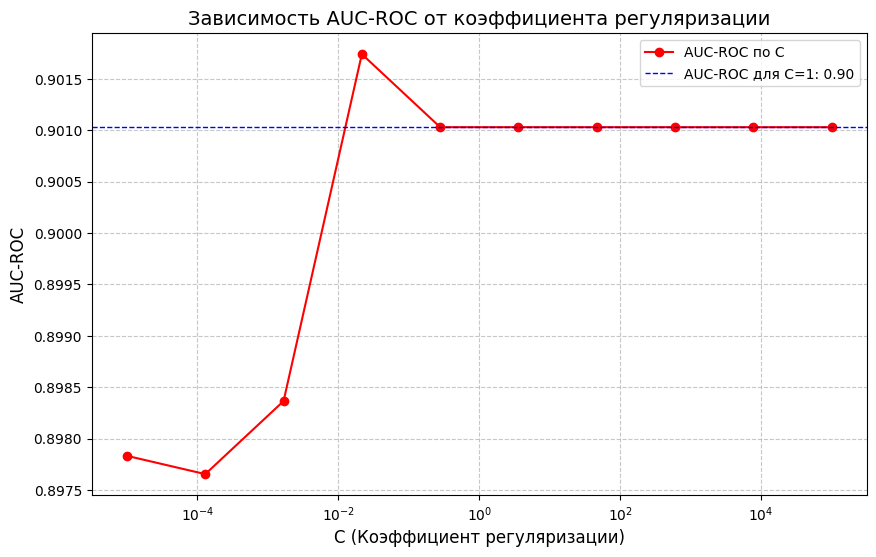

In [ ]:
# Построение графика зависимости AUC-ROC от значения C
plt.figure(figsize=(10, 6))

# Линия зависимости AUC-ROC от C
plt.plot(Cs, scores, marker='o', linestyle='-', color='red', label='AUC-ROC по C')

# Установка логарифмической шкалы для оси X
plt.xscale('log')

# Подписи осей
plt.xlabel('C (Коэффициент регуляризации)', fontsize=12)
plt.ylabel('AUC-ROC', fontsize=12)

# Заголовок графика
plt.title('Зависимость AUC-ROC от коэффициента регуляризации', fontsize=14)

# Добавление горизонтальной линии для AUC-ROC при C=1
plt.axhline(
    y=score_C_1,
    color='blue',
    linestyle='dashed',
    linewidth=1,
    label=f'AUC-ROC для C=1: {score_C_1:.2f}'
)

# Добавление сетки для удобства
plt.grid(visible=True, linestyle='--', alpha=0.7)

# Добавление легенды
plt.legend(fontsize=10)

# Отображение графика
plt.show()


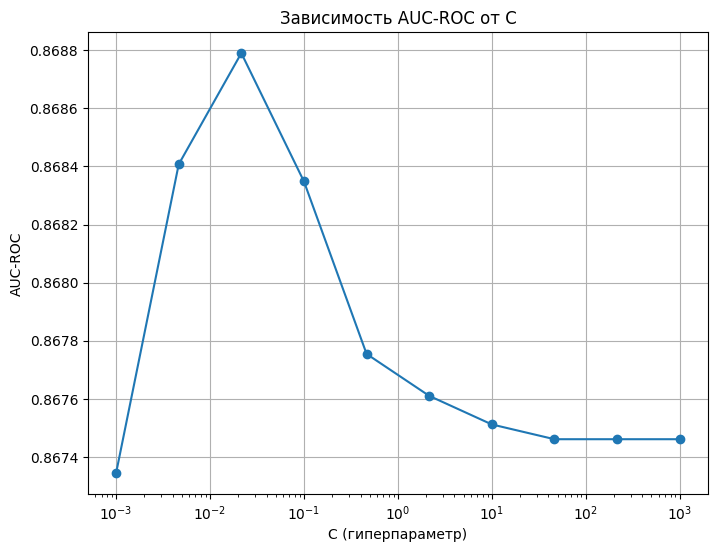

In [ ]:
# 2.3 График зависимости AUC-ROC от C
results = pd.DataFrame(grid.cv_results_)  # Получаем результаты кросс-валидации
plt.figure(figsize=(8, 6))

# Строим график с использованием логарифмического масштаба по оси X
plt.semilogx(results['param_C'], results['mean_test_score'], marker='o')

# Подписи осей и заголовок
plt.xlabel('C (гиперпараметр)')
plt.ylabel('AUC-ROC')
plt.title('Зависимость AUC-ROC от C')

# Добавляем сетку для удобства восприятия
plt.grid()

# Показываем график
plt.show()


In [ ]:
# 3. Сохранение бейслайна в CSV
baseline_metrics = []

# Проходим по каждой строке и добавляем данные в словарь
for i in range(len(df)):
    row_metrics = {
        'quality': df['quality'].iloc[i],  # Замените на доступный столбец, например, 'quality'
        'Best_C': best_C,
        'AUC-ROC': auc_score
    }
    baseline_metrics.append(row_metrics)

# Преобразуем список в DataFrame
baseline_df = pd.DataFrame(baseline_metrics)

# Сохраняем DataFrame в CSV
baseline_df.to_csv('baseline_metrics.csv', index=False)

print("Бейслайн сохранен в CSV.")


Бейслайн сохранен в CSV.


In [ ]:
# Создание DataFrame из списка словарей
baseline_df = pd.DataFrame(baseline_metrics)

# Сохранение в CSV файл
baseline_path = 'baseline_metrics.csv'
baseline_df.to_csv(baseline_path, index=False)


print(baseline_df.head())


   quality    Best_C   AUC-ROC
0        5  0.021544  0.901031
1        5  0.021544  0.901031
2        5  0.021544  0.901031
3        6  0.021544  0.901031
4        5  0.021544  0.901031
